## PNP-VQA: Inference Demo

In [1]:
# install requirements

!git clone https://github.com/salesforce/LAVIS
%cd LAVIS
!pip install .
!pip install transformers==4.25

Cloning into 'LAVIS'...
remote: Enumerating objects: 6693, done.
remote: Counting objects: 100% (1694/1694), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 6693 (delta 1528), reused 1503 (delta 1503), pack-reused 4999
Receiving objects: 100% (6693/6693), 70.97 MiB | 19.94 MiB/s, done.
Resolving deltas: 100% (4257/4257), done.
/content/LAVIS
Processing /content/LAVIS
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 63.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.8/934.8 kB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 30.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 24.8 MB/s eta 0:00:00
Reason for being yanked: Version was not properly set
  Attempting uninstall: transformers
    Found existing installation: transformers 4.33.3
    Uninstalling transformers-4.33.3:
      Successfully uninstalled transformers-4.33.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
salesforce-lavis 1.0.1 requires transformers>=4.28.0, but you have transformers 4.25.0 which is incompatible.


In [2]:
import torch
import requests
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

from lavis.common.gradcam import getAttMap
from lavis.models import load_model_and_preprocess

/usr/local/lib/python3.10/dist-packages/diffusers/models/cross_attention.py:30: FutureWarning: Importing from cross_attention is deprecated. Please import from diffusers.models.attention_processor instead.
  deprecate(


### Load an example image and question

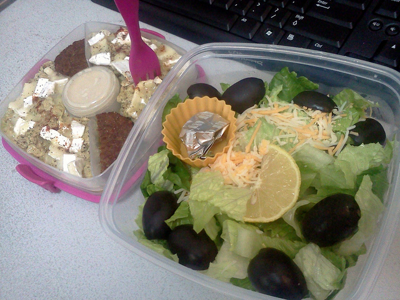

What is the yellow thing on the bowl?


In [14]:

# Define the image URL
img_url = 'https://storage.googleapis.com/sfr-vision-language-research/LAVIS/projects/pnp-vqa/demo.png'

# Open the image from the URL and convert it to RGB format
raw_image = Image.open(requests.get(img_url, stream = True).raw).convert('RGB')

# Display the resized image
display(raw_image.resize((400,300)))

# Define the question
question = "What is the yellow thing on the bowl?"

# Print the question
print(question)

In [15]:
# setup device to use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Load PNP-VQA model

In [16]:
# Load the VQA model and preprocessors
# 'name' specifies the model name (e.g., "pnp_vqa")
# 'model_type' specifies the type of model to load (e.g., "base")
# 'is_eval' indicates that the model is loaded for evaluation
# 'device' specifies the device (e.g., CPU or GPU) to run the model on
model, vis_processors, txt_processors = load_model_and_preprocess(name="pnp_vqa", model_type="base", is_eval=True, device=device)

### Preprocess image and text inputs

In [17]:
# Process the raw image using the visual preprocessor for evaluation; add new dimention to the tensor in axis 0 for batch dimension for hardware acceleration
#Inputes are expected in batches.
image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)

# Process the question using the text preprocessor for evaluation
question = txt_processors["eval"](question)

# Create a dictionary 'samples' containing the processed image and question
samples = {"image": image, "text_input": [question]}


In [18]:
import torch
#Original tensor with shape [N]
original_tensor = torch.tensor([1, 2, 3, 4, 5])

#Add a batch dimension to create a tensor with shape [1, N]
batched_tensor = original_tensor.unsqueeze(0)

print("Original Tensor:", original_tensor)
print("Shape of Original Tensor:", original_tensor.size())
print("Batched Tensor:", batched_tensor)
print("Shape of Batched Tensor:", batched_tensor.size())

Original Tensor: tensor([1, 2, 3, 4, 5])
Shape of Original Tensor: torch.Size([5])
Batched Tensor: tensor([[1, 2, 3, 4, 5]])
Shape of Batched Tensor: torch.Size([1, 5])


### PNP-VQA utilizes 3 submodels to perform VQA:
#### 1. Image-Question Matching
Compute the relevancy score of image patches with respect to the question using GradCAM

In [19]:
# Perform a forward pass of the model for Inference
# 'samples' is a dictionary containing input data for the model
# The model is expected to process and make predictions based on the input data
samples = model.forward_itm(samples=samples)


Question: what is the yellow thing on the bowl?


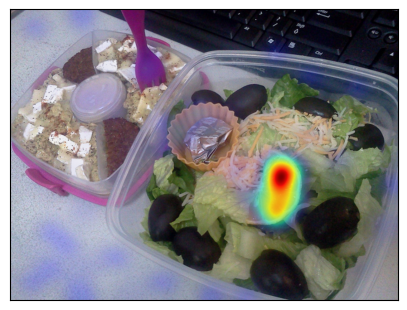

In [20]:
# Perform GradCAM visualization
# Resize the raw image for visualization purposes
dst_w = 720
w,h = raw_image.size
scaling_factor = dst_w/w

# Normalize the resized image to the range [0, 1]
resized_img = raw_image.resize((int(w*scaling_factor),int(h*scaling_factor)))
norm_img = np.float32(resized_img)/255

# Extract the GradCAM information from the 'samples' dictionary
gradcam = samples['gradcams'].reshape(24, 24)

# Generate an average GradCAM map with optional blurring
avg_gradcam = getAttMap(norm_img, gradcam, blur=True)

# Create a matplotlib figure for visualization
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Display the average GradCAM map
ax.imshow(avg_gradcam)

# Remove the axis ticks for a cleaner visualization
ax.set_yticks([])
ax.set_xticks([])

# Print the associated question
print('Question: {}'.format(question))


#### 2. Image Captioning
Generate question-guided captions based on the relevancy score

In [21]:
# Perform caption generation using the model
# 'samples' is a dictionary containing input data for the model
# 'num_captions' specifies the number of captions to generate
# 'num_patches' specifies the number of image patches to use in captioning
samples = model.forward_cap(samples=samples, num_captions=50, num_patches=20)

# Print caption examples
print('Examples of question-guided captions: ')
# Display the first five generated captions for the first sample
print(samples['captions'][0][:5])


Examples of question-guided captions: 
['a bowl of something lemonade dip, lemon, fruit and a lemon wedge', 'a clear container filled with limes and lemon slices', 'in a box of watermeli salad with lemon slices lemon slices, lemon slice', 'the lemon lime lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon', 'a container of food containing lemon slices lemon lemon lemon lemon slice lemon lemon lemon and']


#### 3. Question Answering
Answer the question by using the captions

In [22]:
# Perform question-answering using the model
# 'samples' is a dictionary containing input data for the model
# 'num_captions' specifies the number of captions to consider for answering

pred_answers = model.forward_qa(samples, num_captions=50)

# Print the question and predicted answer
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))


Question: what is the yellow thing on the bowl? 
Predicted answer: lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon lemon


### Generate answer by calling `predict_answers()` directly


In [23]:
# Predict answers, captions, and GradCAM visualization using the model
# 'samples' is a dictionary containing input data for the model
# 'num_captions' specifies the number of captions to consider
# 'num_patches' specifies the number of image patches to use

pred_answers, caption, gradcam = model.predict_answers(samples, num_captions=50, num_patches=20)

# Print the question and predicted answer
print('Question: {} \nPredicted answer: {}'.format(question, pred_answers[0]))


Question: what is the yellow thing on the bowl? 
Predicted answer: lemon lemon slice
